In [109]:
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

train_dir = './data/Driver Drowsiness Dataset (DDD)/sampled' 




In [110]:
import os
import pandas as pd

# create a dictionary to store the number of files in each subdirectory
num_files = {}
for subdir in os.listdir(train_dir):
    path = os.path.join(train_dir, subdir)
    if os.path.isdir(path):
        num_files[subdir] = len(os.listdir(path))

# create a pandas dataframe to display the results in a table
df = pd.DataFrame.from_dict(num_files, orient='index', columns=['Number of Files'])
df.index.name = 'Subdirectory'
display(df)


,Number of Files
Subdirectory,
NonDrowsy,202
Drowsy,235


Randomly pick 100 images from each directory

In [111]:
def data_preprocess_step1(train_dir, num_images=200):
    # create empty lists to store the images and their labels
    images = []
    labels = []

    # loop through each subdirectory
    for subdir in os.listdir(train_dir):
        path = os.path.join(train_dir, subdir)
        print(path)
        if os.path.isdir(path):
            # get a list of all the image files in the subdirectory
            image_files = os.listdir(path)
            # randomly select num_images images from the list
            selected_images = random.sample(image_files, num_images)
            # loop through the selected images
            for image_file in selected_images:
                # load the image using load_img
                
                img = load_img(os.path.join(path, image_file), target_size=(224, 224))
                # convert the image to an array using img_to_array
                img_array = img_to_array(img)
                # append the image and its label to the lists
                images.append(img_array)
                if subdir == "Drowsy":
                    labels.append(1)
                else:
                    labels.append(0)

    # convert the images and labels to numpy arrays
    images = np.stack(images)
    labels = np.array(labels).flatten()
    return images, labels


In [112]:
# generate images and labels based on preprocess_data_part1() function
images, y = data_preprocess_step1(train_dir)

print(f"images_mini shape {images.shape}")
print(f"y_mini shape {y.shape}")

./data/Driver Drowsiness Dataset (DDD)/sampled/NonDrowsy
./data/Driver Drowsiness Dataset (DDD)/sampled/Drowsy
images_mini shape (400, 224, 224, 3)
y_mini shape (400,)


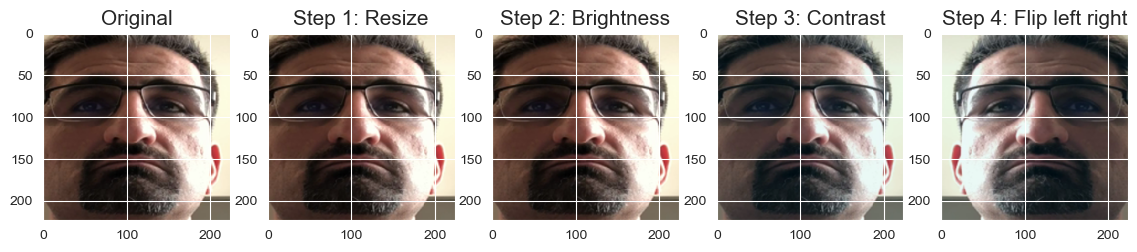

In [113]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(image, size=(224, 224))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);


# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

In [114]:
IMAGE_SIZE = (224, 224)
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data_step2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1235)
    np.random.seed(1235)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])
    
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)
    
    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [115]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_step2(
    images,
    y,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (480, 224, 224, 3)
y_train shape (480,)
X_val shape (80, 224, 224, 3)
y_val shape (80,)
X_test shape (80, 224, 224, 3)
y_test shape (80,)


Print training data examples:


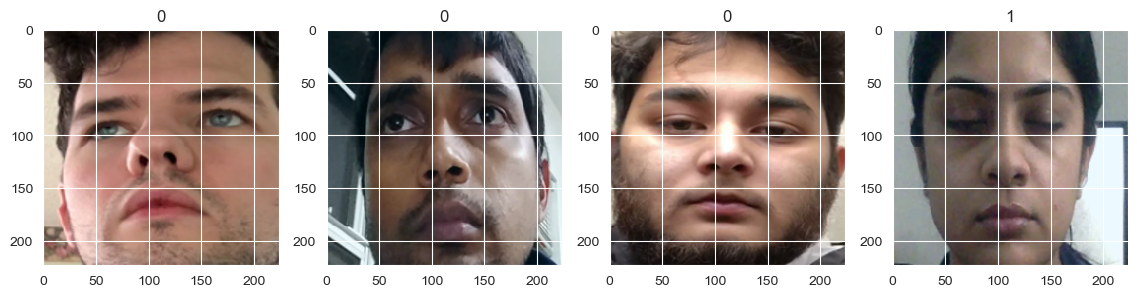

In [116]:
# print taining data
print('Print training data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_train[i]))
    axs[i].set(title=y_train[i])

Print validation data examples:


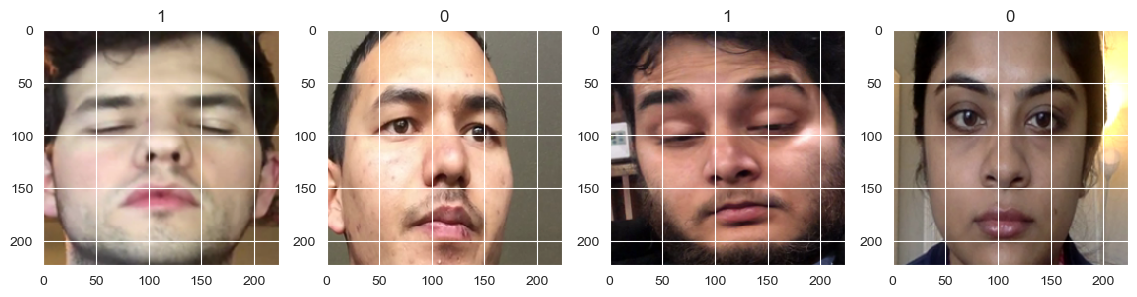

In [117]:
# print test data
print('Print validation data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_val[i]))
    axs[i].set(title=y_val[i])

In [118]:
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))


# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits 
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)
model.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation=None))

# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 112, 112, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 112, 112, 64)      51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 56, 56, 64)        0         
                                                                 
 flatten_8 (Flatten)         (None, 200704)            0         
                                                                 
 fc_1 (Dense)                (None, 1024)              205521920 
                                                                 
 dropout_8 (Dropout)         (None, 1024)             

In [119]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 

In [120]:
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, y_train,
                    epochs=15, 
                    validation_data=(X_val, y_val)
)

Epoch 1/15


2023-11-24 12:47:49.109186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 10.7815 - accuracy: 0.4854

2023-11-24 12:47:58.587331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 11s 629ms/step - loss: 10.7815 - accuracy: 0.4854 - val_loss: 0.7855 - val_accuracy: 0.4000
Epoch 2/15
15/15 [==============================] - 9s 597ms/step - loss: 0.7050 - accuracy: 0.4958 - val_loss: 0.6899 - val_accuracy: 0.5375
Epoch 3/15
15/15 [==============================] - 9s 597ms/step - loss: 0.6930 - accuracy: 0.4917 - val_loss: 0.6878 - val_accuracy: 0.5375
Epoch 4/15
15/15 [==============================] - 9s 614ms/step - loss: 0.6861 - accuracy: 0.5021 - val_loss: 0.6788 - val_accuracy: 0.5375
Epoch 5/15
15/15 [==============================] - 9s 610ms/step - loss: 0.6030 - accuracy: 0.6062 - val_loss: 0.5779 - val_accuracy: 0.6125
Epoch 6/15
15/15 [==============================] - 9s 604ms/step - loss: 0.4237 - accuracy: 0.7417 - val_loss: 0.6040 - val_accuracy: 0.7125
Epoch 7/15
15/15 [==============================] - 9s 597ms/step - loss: 0.2923 - accuracy: 0.8625 - val_loss: 0.5727 - val_accuracy: 0.6500
Epoch 8/15
15/1

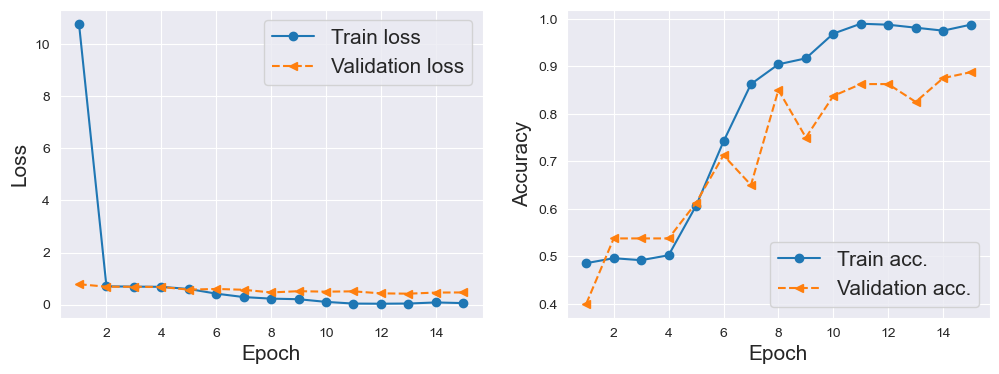

In [121]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [122]:
test_results = model.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

3/3 [==============================] - 0s 146ms/step - loss: 0.1912 - accuracy: 0.9500

Test Acc. 95.00%


Shape of image: (1, 224, 224, 3)


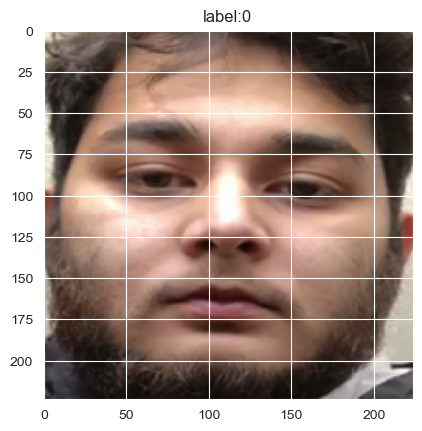

In [123]:
img_tensor = np.expand_dims(X_train[2], axis = 0)

# Print image tensor shape
print('Shape of image:', img_tensor.shape)
  
# Print image
plt.imshow(img_tensor[0])
plt.title('label:' + str(y_train[1]))
plt.show()

1/1 [==============================] - 0s 72ms/step


2023-11-24 12:50:48.639786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


----------------
Geeting activations of layer 1 : conv_1
Images size is 224 x 224
Number of channels is 32
Printing channels:


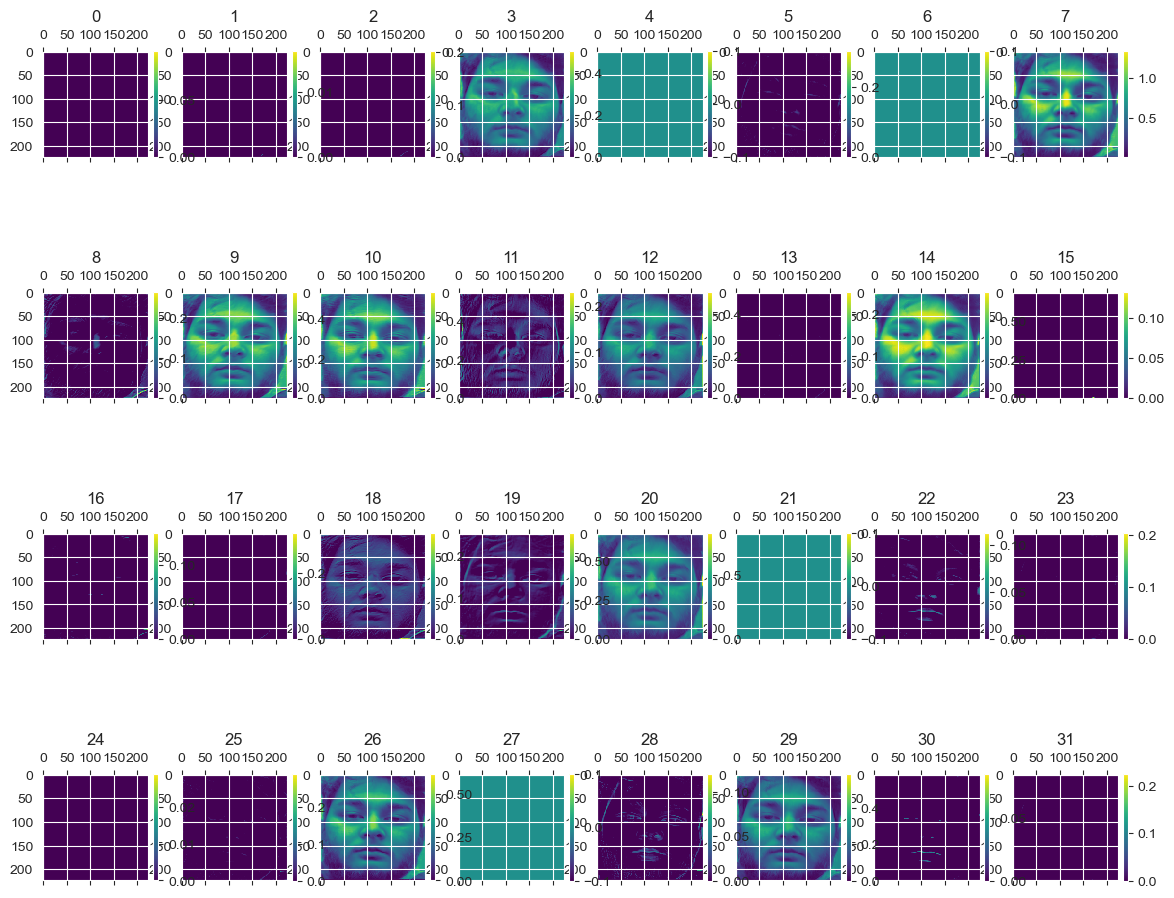

----------------
Geeting activations of layer 2 : pool_1
Images size is 112 x 112
Number of channels is 32
Printing channels:


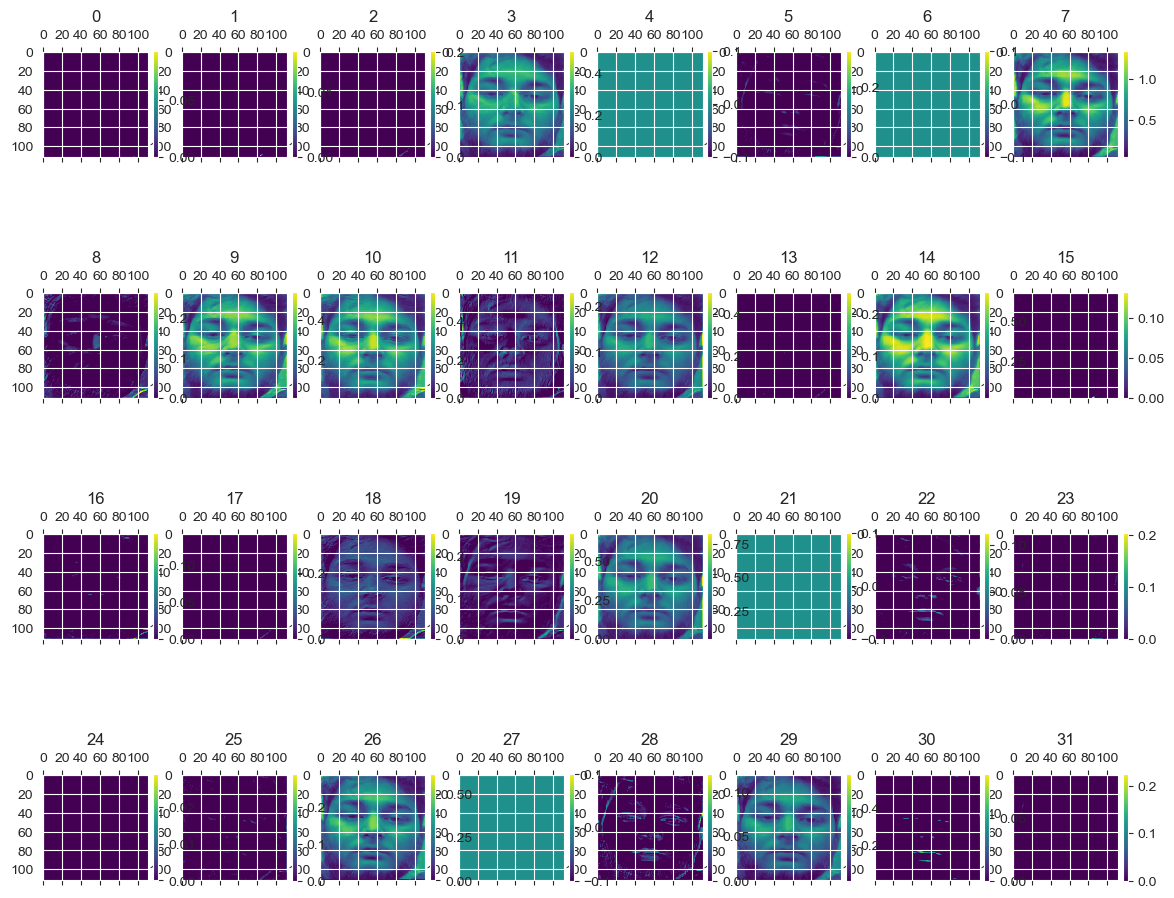

----------------
Geeting activations of layer 3 : conv_2
Images size is 112 x 112
Number of channels is 64
Printing channels:


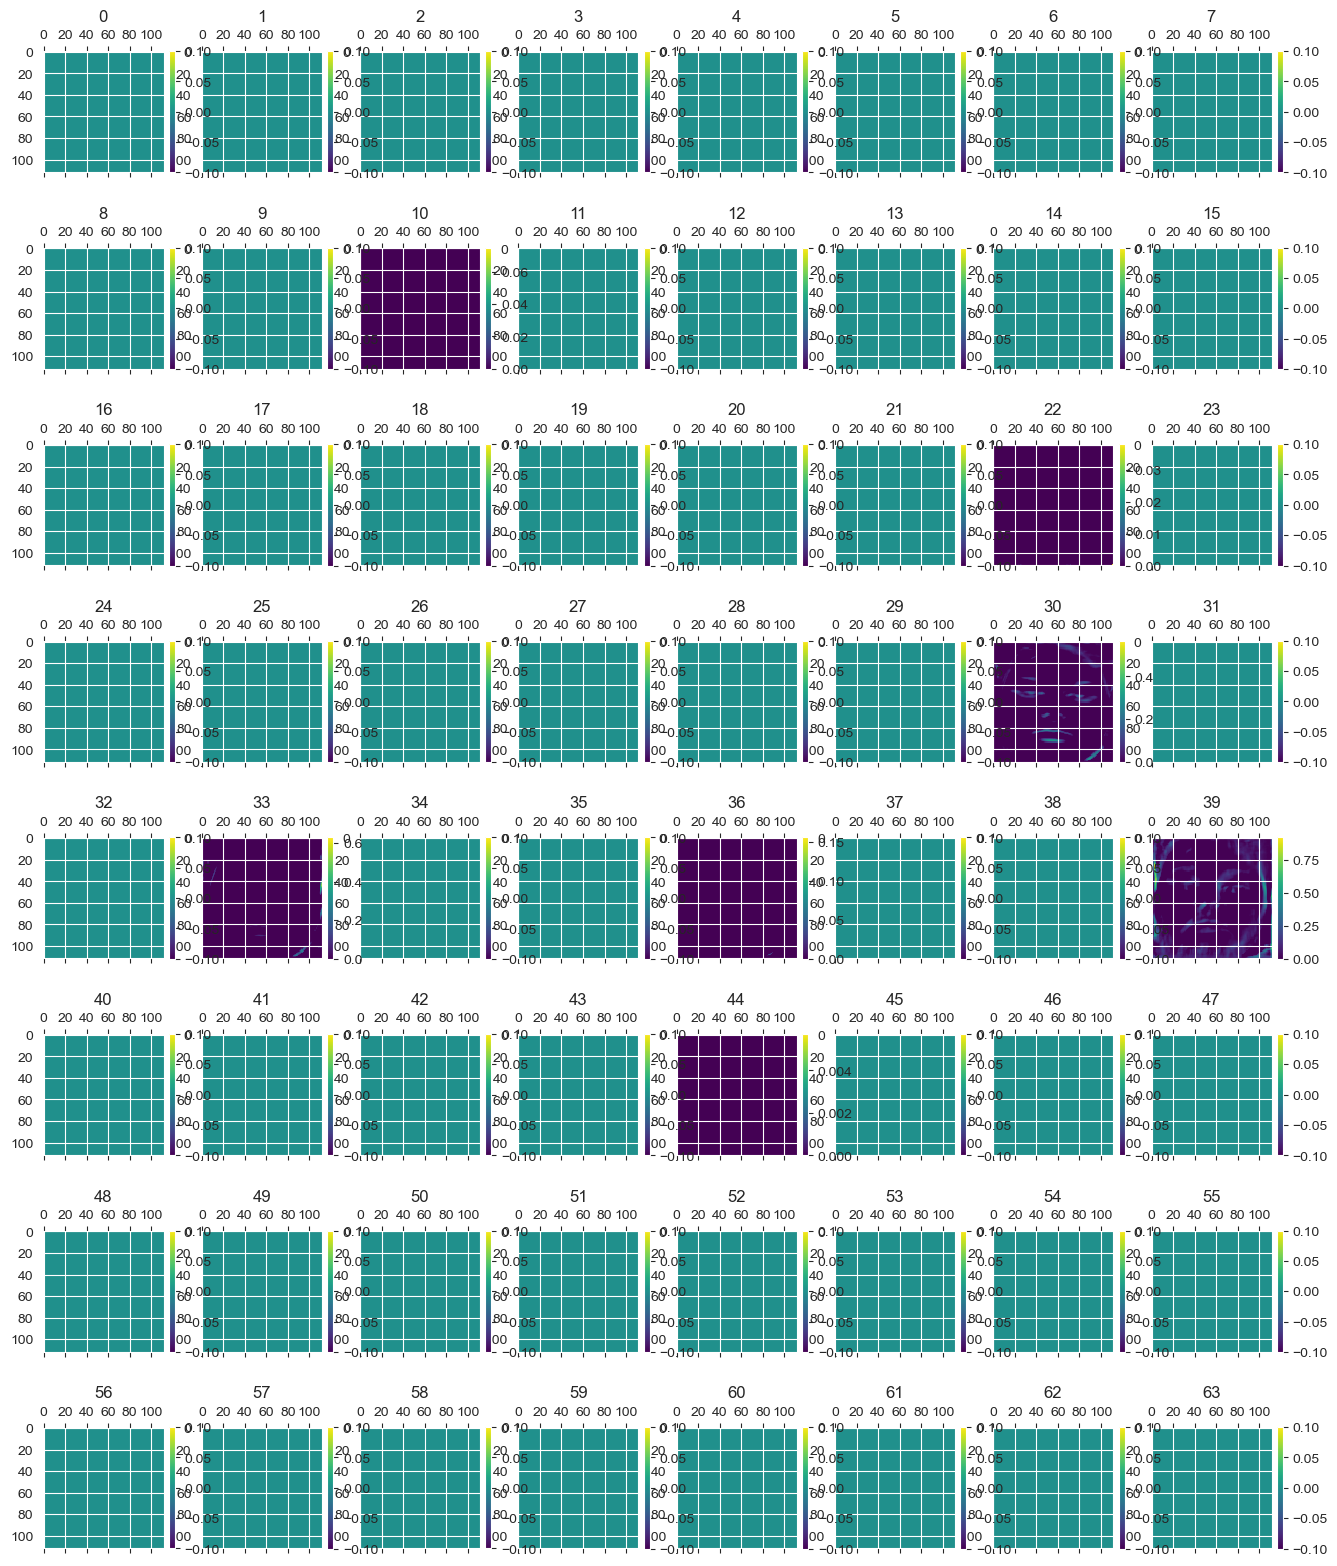

----------------
Geeting activations of layer 4 : pool_2
Images size is 56 x 56
Number of channels is 64
Printing channels:


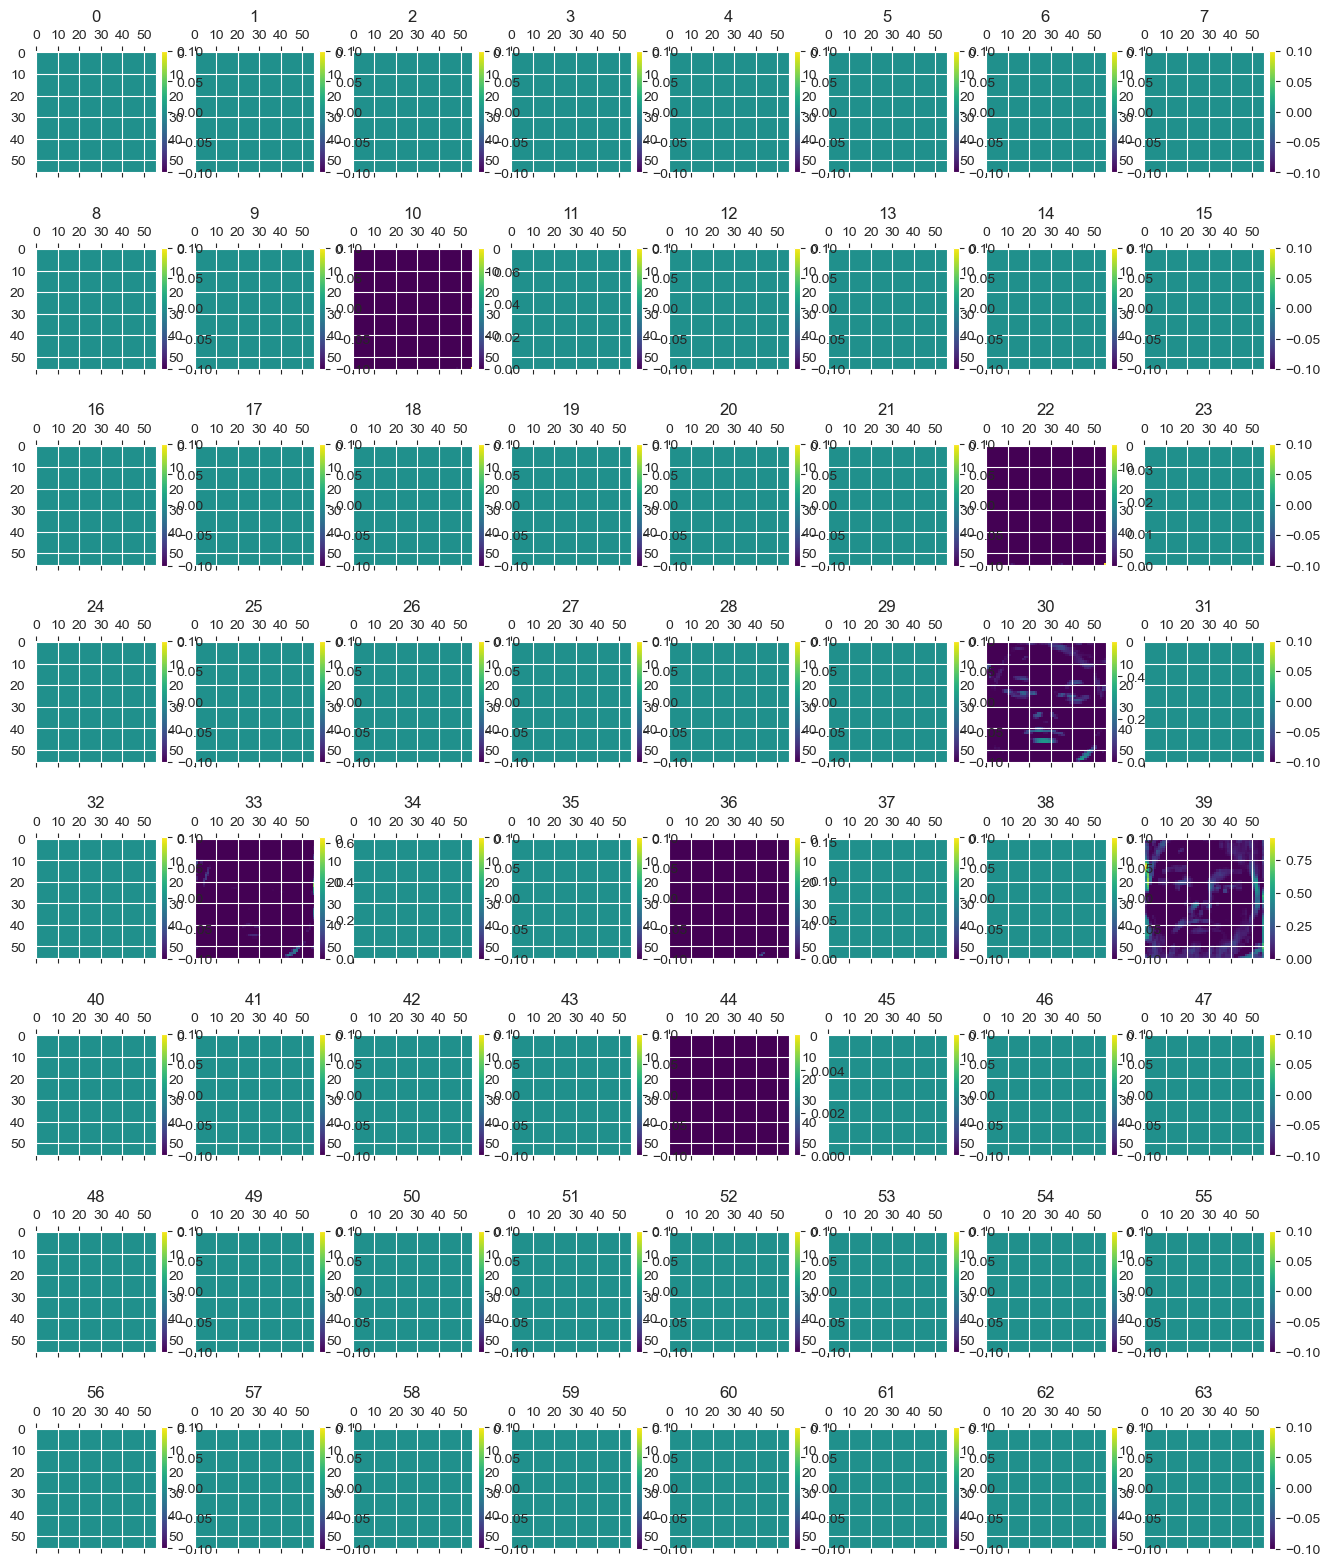

In [124]:
# outputs of the first 4 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:4]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)

# grab layer names
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)

# getting activations of each layer
for idx, layer in enumerate(activations):
    if idx in (0,1,2,3):
        print('----------------')
        print('Geeting activations of layer',  idx+1, ':', layer_names[idx])
        activation = layer

        # shape of layer activation
        print('Images size is', activation.shape[1], 'x', activation.shape[2])
        print('Number of channels is', activation.shape[3])

        # print channels
        print('Printing channels:')
        
        # define nrows and ncols depending on number of channels
        if idx in (0,1):
            nrows, ncols = 4,8
        if idx in (2,3):
            nrows, ncols = 8,8

        # plots
        channel=0
        if idx in (0,1):
            f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
        if idx in (2,3):
            f, axs = plt.subplots(nrows, ncols, figsize=(16,20))
            
        for i in range(nrows):
            for j in range(ncols):
                if i==0 and j==0:
                    channel=0
                else:
                    channel+=1

                im = axs[i,j].matshow(activation[0,:, :, channel], cmap ='viridis')
                axs[i,j].set(title=str(channel))
                plt.colorbar(im, ax=axs[i, j], fraction=0.046, pad=0.04)
                #axs[i,j].axis('off') # pay attention to the range of x and y axis
        
        plt.show()
        